# Calculating the Temporal Decay of $g^{(1)}(t)$ Using Python

---

<div class="alert alert-block alert-info">
We recommend viewing this notebook with <a href="https://nbviewer.jupyter.org/github/KOrfanakis/Coherence_from_Interferometry/blob/main/Analysis.ipynb">nbviewer</a>
.
</div>

<br>

**Table of contents**

- [Libraries and Default Parameters](#Libraries-and-Default-Parameters)
- [Functions](#Functions)
    - [`fitting_function()`](#fitting_function(%29) <br>
    - [`summary_fitting()`](#summary_fitting(%29) <br>
    - [`error_calculation()`](#error_calculation(%29) <br>
    - [`moving_average()`](#moving_average(%29)
- [Importing Data](#Importing-Data)
- [Data Preprocessing](#Data-Preprocessing)
    - [Rotation](#Rotation) <br>
    - [Cropping](#Cropping)
- [Fitting](#Fitting)
    - [Fitting the First Interferogram](#Fitting-the-First-Interferogram) <br>
    - [Fitting All Interferograms](#Fitting-All-Interferograms)
- [Results](#Results)

<br>

# Libraries and Default Parameters

In [1]:
import h5py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lmfit import Model
from scipy import ndimage
from scipy.stats import linregress
from tqdm.notebook import tqdm

In [2]:
import watermark
%load_ext watermark

# See version of system, Python, and libraries
%watermark -n -v -m -iv

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.0.1

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit

numpy     : 1.22.2
scipy     : 1.8.0
matplotlib: 3.5.1
watermark : 2.3.0
pandas    : 1.4.1
h5py      : 3.6.0
json      : 2.0.9



In [3]:
np.random.seed(42)
%config InlineBackend.figure_format = 'retina'

font_size = 18
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 1.5

plt.rcParams['lines.markersize'] = 8
plt.rcParams['lines.linewidth'] = 2

<br>

# Functions

## `fitting_function()`

As mentioned in the project's [README](https://github.com/KOrfanakis/Coherence_from_Interferometry/blob/main/README.md) file, the line profile extracted from the centre of an interferogram can be fit by a Gaussian function multiplied by a cosine. The exact equation is the following:

$f(x; A, x_{0}, w, \alpha, k, \phi, ct) = A \cdot exp(-\frac{(x - x_{0})^{2}}{2w^{2}})(\alpha \cdot cos(k\cdot x + \phi) + 1) + ct$

Where parameters $A$, $x_{0}$, and $w$ are the amplitude, the centre, and the width of the Gaussian function. The  parameter $\alpha$ corresponds to the fringe contrast, $k$ to the wavenumber, $\phi$ to the phase, and $ct$ to a constant.

We are interested in extracting the **fringe contrast** since it is equal to the magnitude of the first-order correlation function $|g^{(1)}(t)|$, where $t$ is the time delay.

In [4]:
def fitting_function(x, amp, cen, wid, a, k, phi, ct):
    return amp * np.exp(-(x - cen)**2 / (2 * wid**2)) * (a * np.cos(k * x + phi) + 1) + ct


model = Model(fitting_function)

<br>

## `summary_fitting()`

In [5]:
def summary_fitting(result):
    index = ['R^{2}', 'chi^{2}', 'Contrast', 'Amplitude', 'Centre', 'Width', 'k', 'phi', 'ct']

    values = [r_value**2, result.chisqr, result.params['a'].value,
              result.params['amp'].value, result.params['cen'].value,
              result.params['wid'].value, result.params['k'].value,
              result.params['phi'].value, result.params['ct'].value]
    
    errors = ['-', '-', result.params['a'].stderr, result.params['amp'].stderr,
              result.params['cen'].stderr, result.params['wid'].stderr,
              result.params['k'].stderr, result.params['phi'].stderr,
              result.params['ct'].stderr]

    df = pd.DataFrame(data={'Value': values, 'Error': errors}, index=index)

    return df

<br>

## `error_calculation()`

Standard Error of the Mean:

$\delta x = \sqrt{\frac{\sum_{i = 1}^{N}(x_{i} - \bar{x})^{2}}{N(N - 1)}}$

Where:

- $\bar {x}$ is the sample's mean;
- $N$ is the sample size;

In [6]:
def error_calculation(data):
    N = len(data)
    mean_value = np.mean(data)

    return np.sqrt(np.sum((data - mean_value)**2) / (N * (N - 1)))

<br>

## `moving_average()`

In [7]:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)

    return np.convolve(interval, window, 'same')

<br>

# Importing Data

Before importing the data, we need to specify the following parameters:
-	The number of frames we measure in each position (for averaging),
-	The step of the retroreflector (in mm),
-	The retroreflector position corresponding to the zero delay, and
-	The filename of the H5 file.

<br>

**Note**: The retroreflector is mounted on a motorised stage with a translation range of 300 mm. The value passed in the `zero_delay` parameter corresponds to the position of the retroreflector on the stage. However, the exact reading of position is not relevant as it will later (cell 22) be referenced based on the time delay. 


To calculate the retroreflector position corresponding to zero delay, we form an interferogram at an excitation power slightly below the condensation threshold. Then we find the retroreflector position where the fringes change orientation (see image below).

<img src="Images/Zero_delay.png" style="width: 400px;"/>



In [8]:
frames_per_position = 5
step = 1
zero_delay = 238.2

filename = 'Interference_Data'

In [9]:
file = h5py.File('{}.h5'.format(filename), 'r')

print('✔️ Data Imported Successfully!\n')

keys = list(file.keys())
num_of_frames = len(keys)
number_of_positions = int(num_of_frames / frames_per_position)

print(' - Number of frames: {}'.format(num_of_frames))
print(' - Frames recorded in each retroreflector position: ', frames_per_position)
print('  → Number of positions recorded: {}/{} = {}'.format(num_of_frames, frames_per_position, number_of_positions))

print('\n - Retroreflector step: {} mm'.format(step))
print('  → Distance covered in this dataset: {} positions·{} mm = {} mm'.format(number_of_positions, step, step * number_of_positions))

✔️ Data Imported Successfully!

 - Number of frames: 905
 - Frames recorded in each retroreflector position:  5
  → Number of positions recorded: 905/5 = 181

 - Retroreflector step: 1 mm
  → Distance covered in this dataset: 181 positions·1 mm = 181 mm


We conclude this section by storing the data as a list of dictionaries, with each dictionary corresponding to one frame.

In [10]:
data = []

for index in range(num_of_frames):
    frame_element = keys[index]
    frame = file[frame_element][...]
    frame = frame.T
    frame = frame / frame.max()

    data.append({
        'Frame Name': frame_element,
        'Data': frame,
        'Position': file[frame_element].attrs['Pos']
    })

<br>

# Data Preprocessing

## Rotation

Due to the alignment of our experimental setup, the orientation of the interference fringes rotates as the retroreflector moves. To correct this issue, we rotate the first and last frames so that the interference fringes become vertical. By knowing the rotation angle for these two frames, we can construct a linear array for the rotation angles of all frames in our data.

First frame:


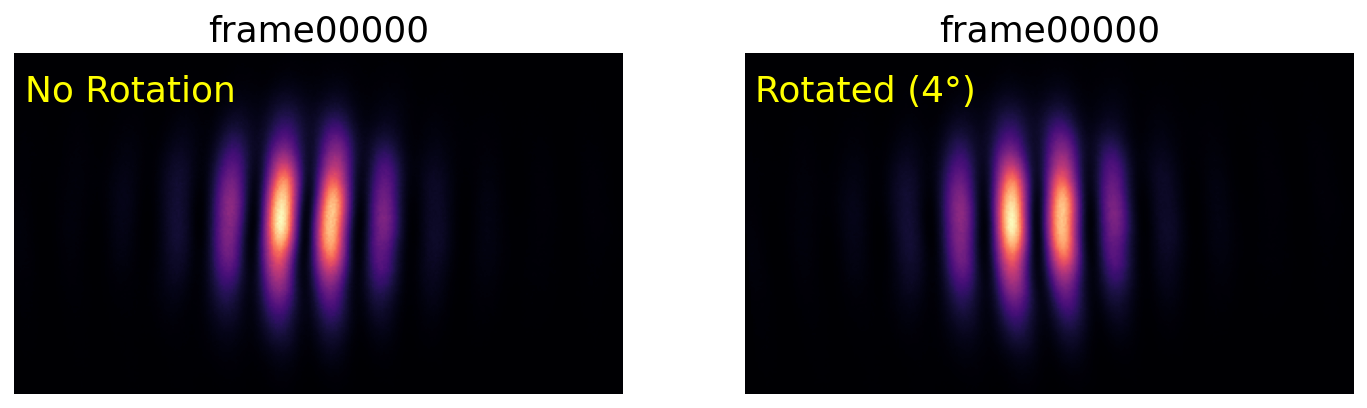

In [11]:
index = 0
angle_i = 4

print('First frame:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for rot, label, ax in zip([0, angle_i], ['No Rotation', 'Rotated ({}°)'.format(angle_i)], [ax1, ax2]):

    img = ndimage.rotate(data[index]['Data'], rot, reshape=False)

    ax.imshow(img, cmap='magma')
    ax.text(5, 25, label, color='yellow', size=font_size)

    ax.set_title(data[index]['Frame Name'])
    ax.axis('off');

Last frame:


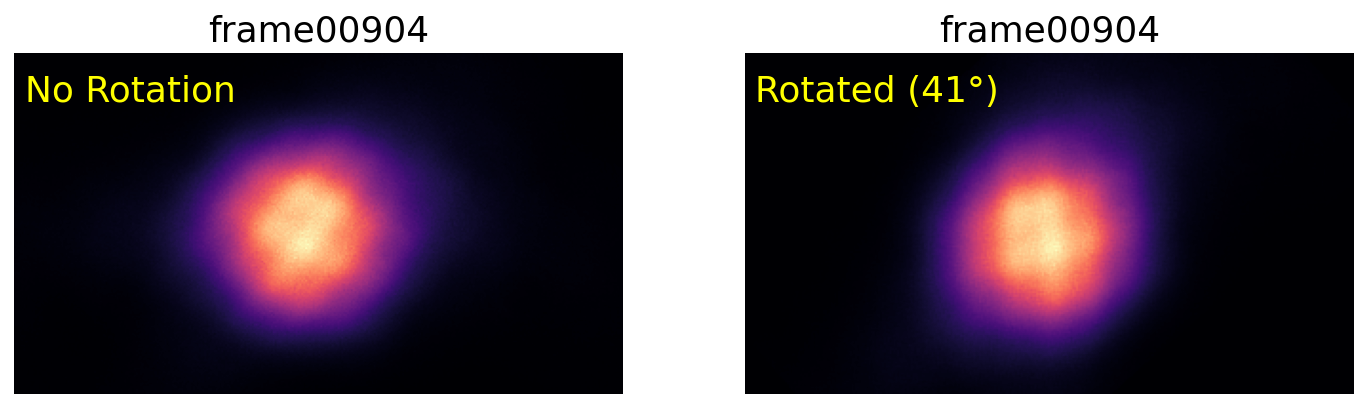

In [12]:
index = num_of_frames - 1
angle_f = 41

print('Last frame:')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for rot, label, ax in zip([0, angle_f], ['No Rotation', 'Rotated ({}°)'.format(angle_f)], [ax1, ax2]):

    img = ndimage.rotate(data[index]['Data'], rot, reshape=False)

    ax.imshow(img, cmap='magma')
    ax.text(5, 25, label, color='yellow', size=font_size)

    ax.set_title(data[index]['Frame Name'])
    ax.axis('off');

In [13]:
angles = np.linspace(angle_i, angle_f, number_of_positions)
angles = np.repeat(angles, frames_per_position)

for index in range(len(data)):
    data[index]['Data'] = ndimage.rotate(data[index]['Data'],
                                         angles[index],
                                         reshape=False)

<br>

## Cropping

The second preprocessing step involves cropping the 2D images so that only interference fringes are included.

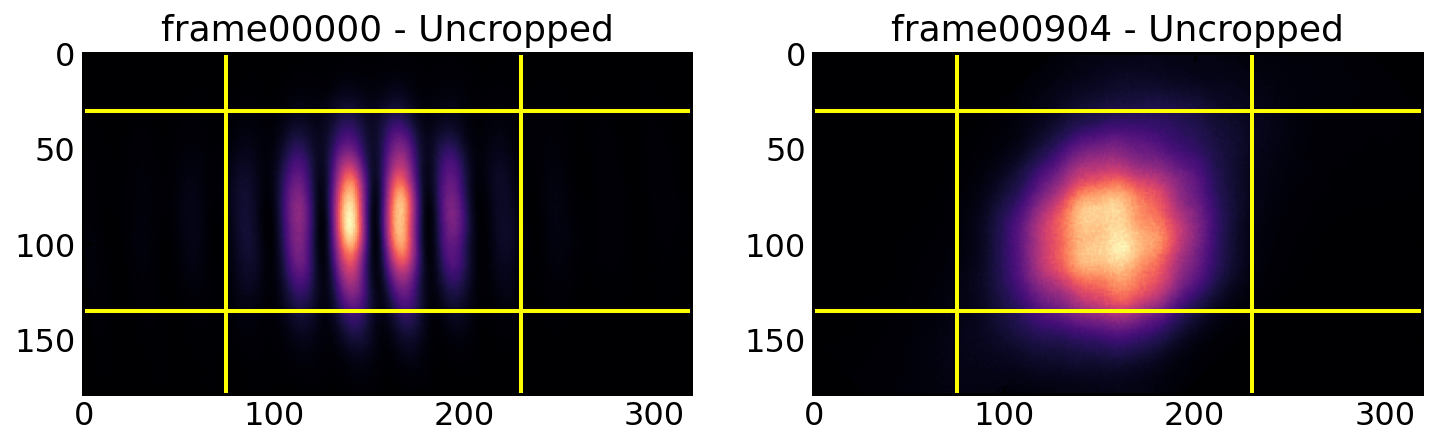

In [14]:
x_left, x_right = 75, 230
y_up, y_down = 30, 135

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for index, ax in zip([0, -1], [ax1, ax2]):

    ax.imshow(data[index]['Data'], cmap='magma')

    ax.set_title(data[index]['Frame Name'] + ' - Uncropped')

    ax.axvline(x=x_left, color='yellow')
    ax.axvline(x=x_right, color='yellow')

    ax.axhline(y=y_up, color='yellow')
    ax.axhline(y=y_down, color='yellow');

In [15]:
for index in range(len(data)):
    data[index]['Data'] = data[index]['Data'][y_up:y_down, x_left:x_right]

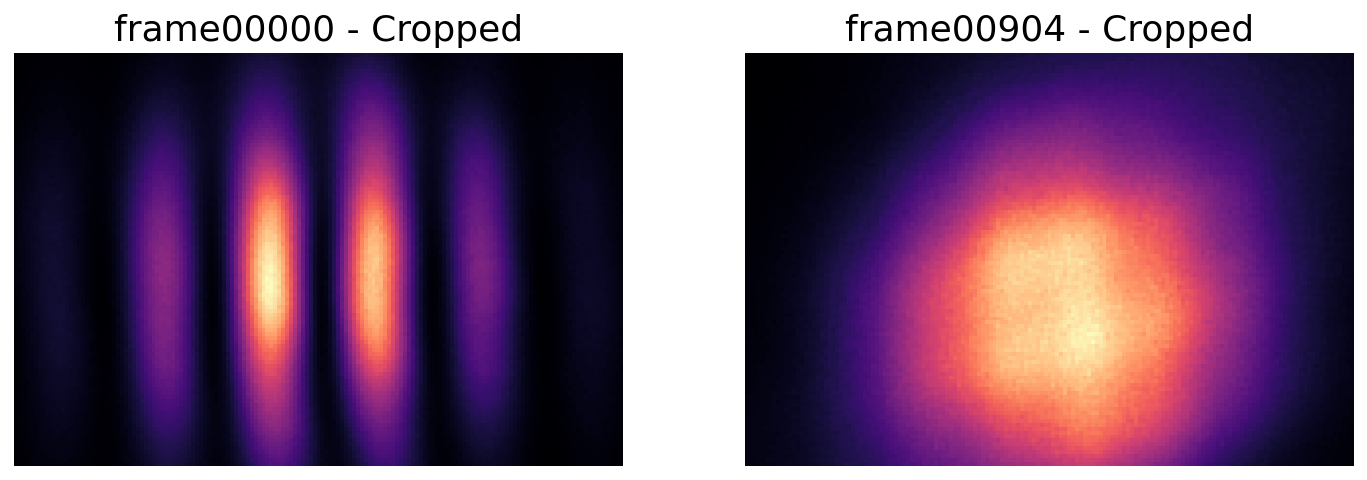

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

for index, ax in zip([0, -1], [ax1, ax2]):

    ax.imshow(data[index]['Data'], cmap='magma')

    ax.set_title(data[index]['Frame Name'] + ' - Cropped')
    ax.axis('off');

<br>

# Fitting

## Fitting the First Interferogram

The first step of our fitting procedure involves extracting the line profile at the centre of the interference pattern of the first frame. The line profile is then fitted to the equation described above. For each fitting parameter, we specify an estimated value, along with appropriate constraints.

In [17]:
img = data[0]['Data']
max_y, max_x = np.unravel_index(img.argmax(), img.shape)

x = np.arange(0, data[0]['Data'].shape[1])
y = img[max_y, :]

In [18]:
k_val = 2 * np.pi / 30

model.set_param_hint('amp', value=0.50, min=0.0, max=10)
model.set_param_hint('cen', value=75, min=25, max=120)
model.set_param_hint('wid', value=30, min=15, max=50)
model.set_param_hint('a', value=0.7, min=-1, max=1)
model.set_param_hint('k', value=k_val, min=k_val - 0.07, max=k_val + 0.12)
model.set_param_hint('phi', value=5, min=0, max=2 * np.pi)
model.set_param_hint('ct', value=0.05, min=0.0, max=0.4)
params = model.make_params()

result = model.fit(y, params, x=x)
slope, intercept, r_value, p_value, std_err = linregress(y, result.best_fit)

,Value,Error
R^{2},0.997633,-
chi^{2},0.026896,-
Contrast,0.990795,0.009472
Amplitude,0.516364,0.003336
Centre,75.729256,0.12067
Width,28.242092,0.176125
k,0.224007,0.000264
phi,4.523062,0.020674
ct,0.019061,0.00261


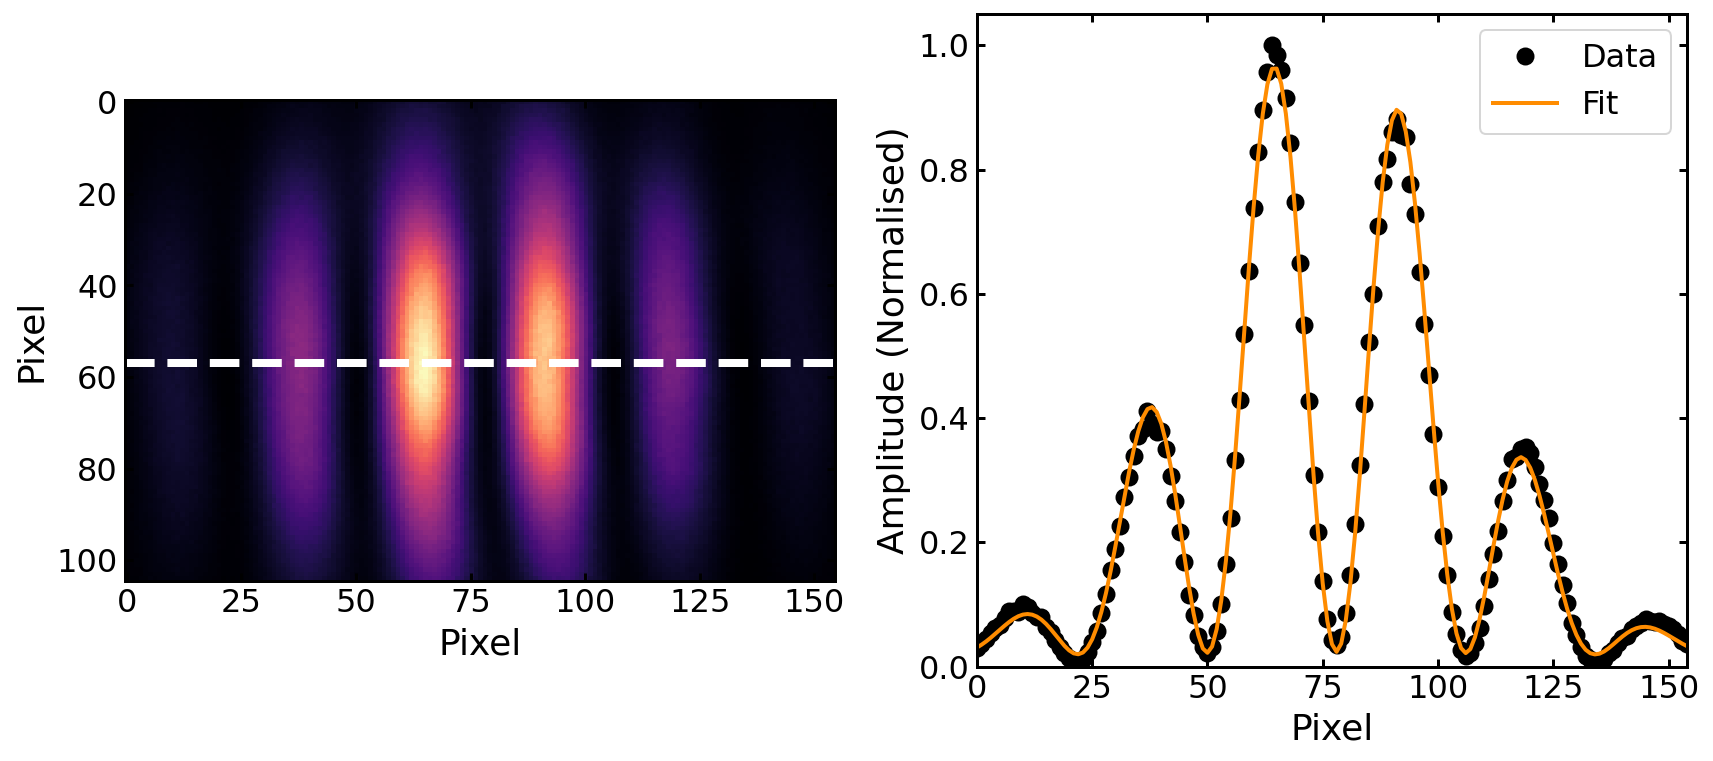

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(img, cmap='magma')
ax1.axhline(y=max_y, color='white', ls='--', lw=4)

ax1.set(xlabel='Pixel', ylabel='Pixel')

ax2.plot(x, y, color='black', marker='o', ls='', label='Data')
ax2.plot(x, result.best_fit, color='darkorange', label='Fit')

ax2.set(xlabel='Pixel', ylabel='Amplitude (Normalised)')

ax2.autoscale(axis='x', tight=True)
ax2.set_ylim(bottom=0)
ax2.legend()

summary_fitting(result)

The fit to our experimental data is excellent. This observation is accompanied by a high coefficient of determination, $R^{2}$ ($\approx 99.7$%).

<br>

## Fitting All Interferograms

We repeat the same process (using the same estimates and constraints) for all frames. The goodness of each fit is assessed using its $R^{2}$. Specifically, we start by setting a threshold slightly below the value of the first fit (see above). In our case, this value is 99.7%, so our threshold is 99.5%. 

Once the fitting procedure is complete, we compare its $R^{2}$ to the threshold:
- If it is higher than the threshold, the contrast value from the fit is stored in a NumPy array, and we proceed to the next frame.
- If not, we assign a new random value between 0 and 2$\pi$ to the `phi` parameter and re-fit for the same frame. This step is repeated until $R^{2} > threshold$. If we cannot get a satisfying fit after 25 trials, we lower the $R^{2}$ threshold (to 99%). If the fitting is still not adequate after ten new trials, we consider that frame’s contrast equal to zero and move on to the next frame. Frames that are not fitted will be excluded from the calculation of the average contrast.

Finally, we plot a sample of line profiles along with their fits for visual inspection.

  0%|          | 0/905 [00:00<?, ?it/s]


Frames [] were not be fitted.



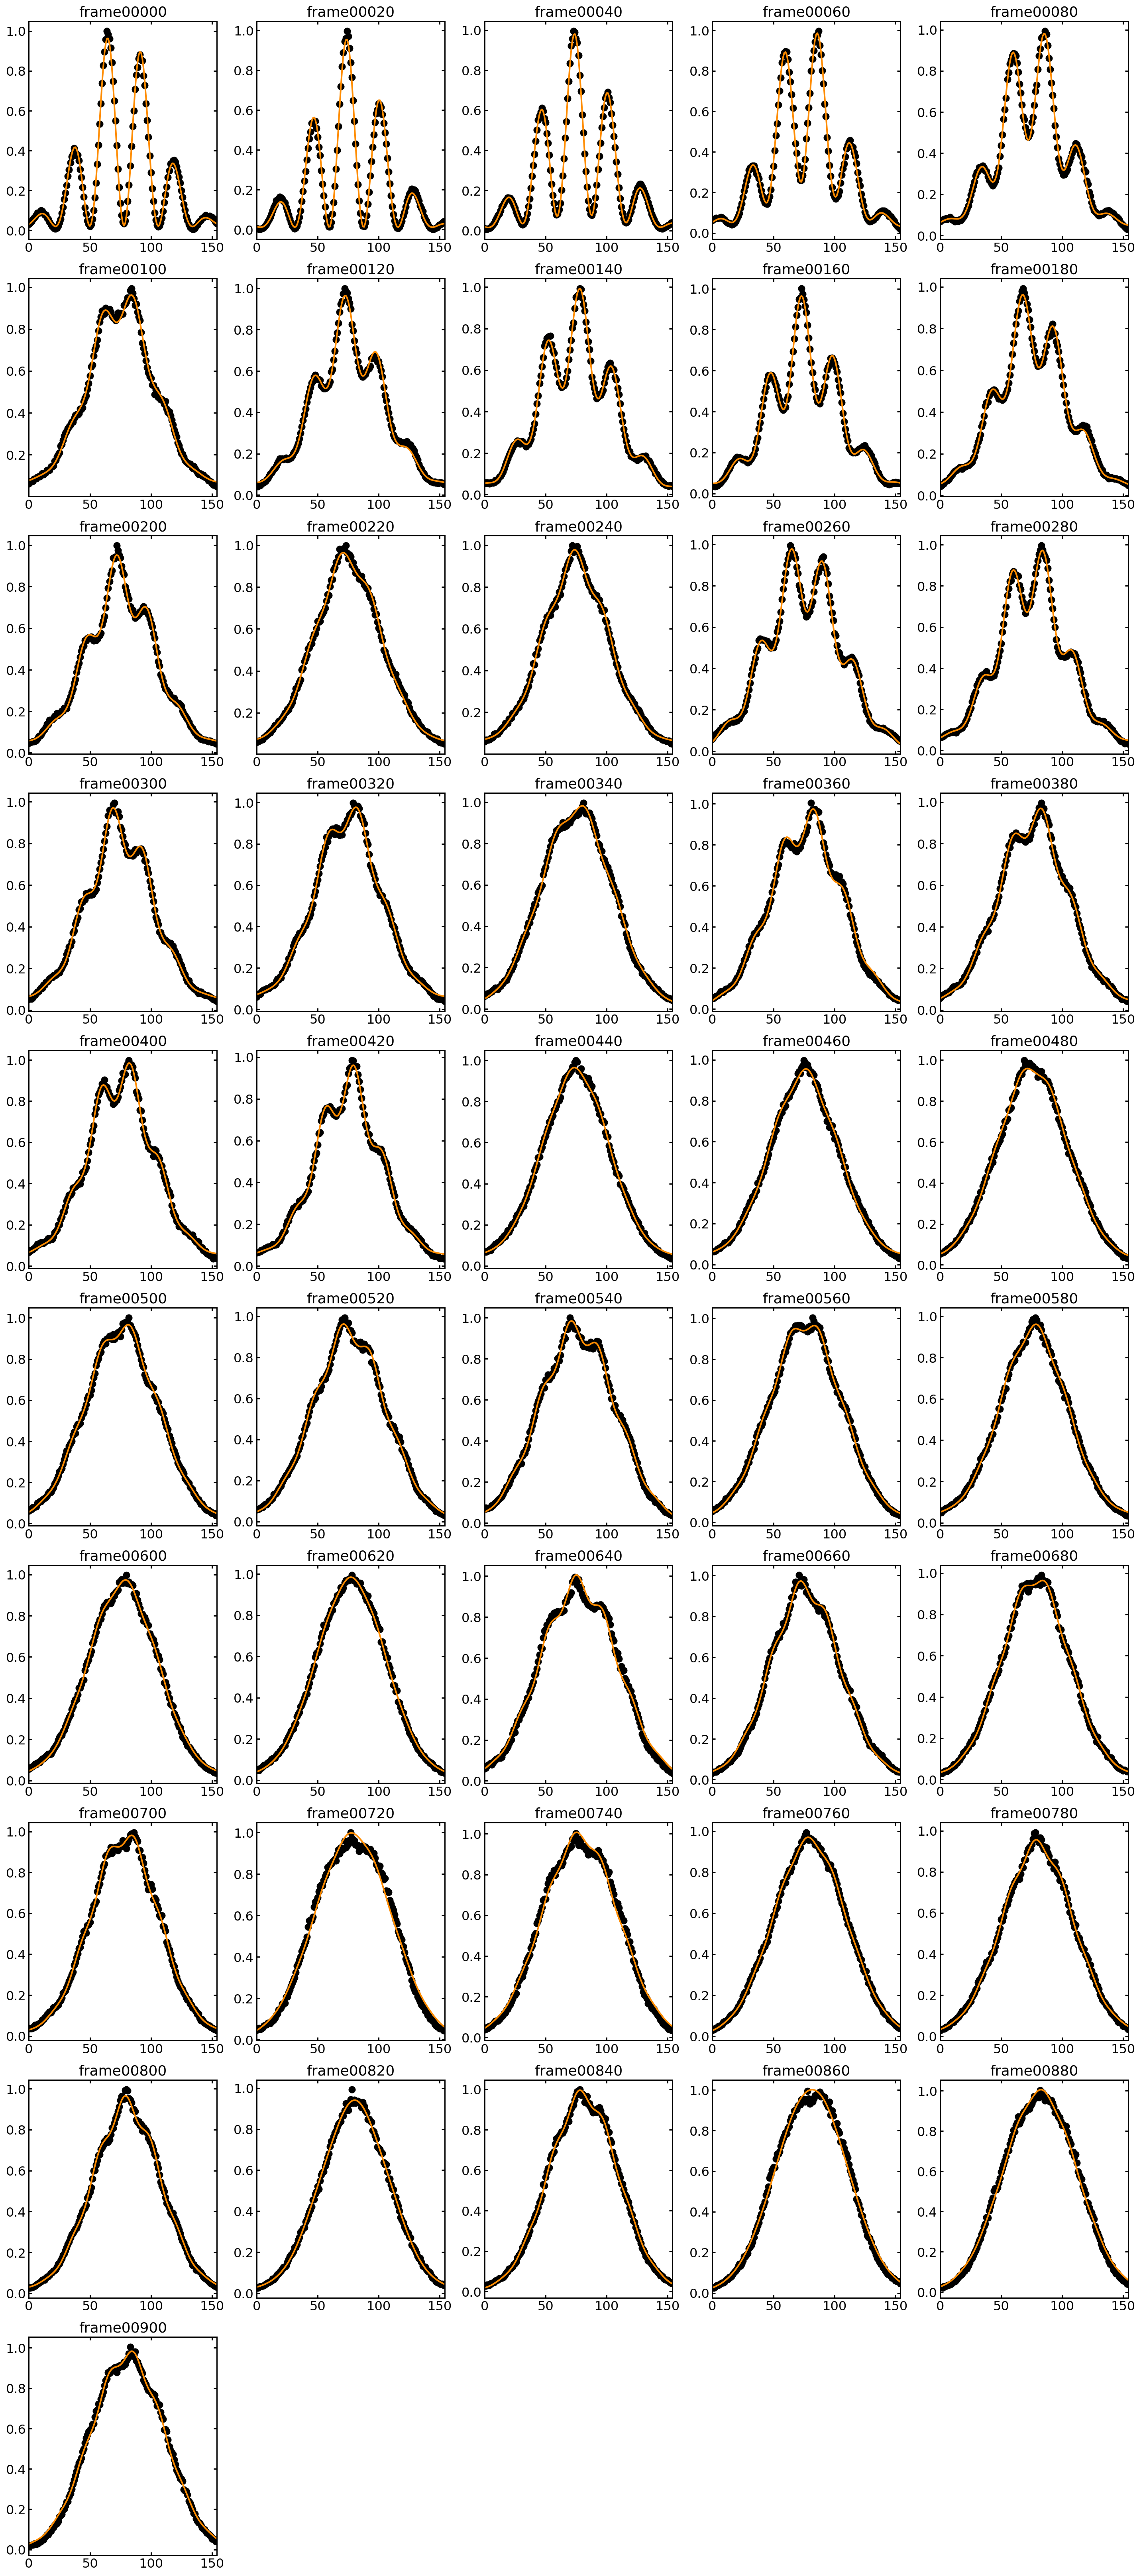

In [20]:
r_sqr_init = 0.995
contrast_arr, contrast_err_arr = np.zeros(num_of_frames), np.zeros(num_of_frames)
frames_fitted, not_fitted = np.full(num_of_frames, False), np.array([])
r_sqr_arr = np.zeros(num_of_frames)

fig = plt.figure(figsize=(20, 45))

index = 1
for i in tqdm((range(0, num_of_frames))):

    r_sqr_val = r_sqr_init

    img = data[i]['Data']
    max_y, max_x = np.unravel_index(img.argmax(), img.shape)
    x, y = np.arange(0, data[i]['Data'].shape[1]), img[max_y, :]

    n_tries = 0
    while (True):

        result = model.fit(y, params, x=x)
        slope, intercept, r_value, p_value, std_err = linregress(y, result.best_fit)

        if r_value**2 > r_sqr_val:

            contrast_arr[i] = np.abs(result.params['a'].value)
            contrast_err_arr[i] = result.params['a'].stderr
            frames_fitted[i] = True
            r_sqr_arr[i] = r_value**2

            #  Plot only a sample of frames.
            if i % 20 == 0:
                ax = plt.subplot(10, 5, index)

                ax.plot(x, y, 'ko', label='Experimental Data')
                ax.plot(x, result.best_fit, color='darkorange', label='Fit')

                ax.set_title(data[i]['Frame Name'])
                ax.autoscale(axis='x', tight=True)
                index += 1

            break

        #  If the fit is not satisfying, change phi.
        else:
            phi_val = 2 * np.pi * np.random.rand()
            model.set_param_hint('phi', value=phi_val, min=-2 * np.pi, max=2 * np.pi)
            params = model.make_params()

        #  If after 25 trials the fit is still not satisfying, lower the threhsold.
        if n_tries == 25:
            r_sqr_val -= 0.005

        #  After 35 trials, proceed to the next frame.
        if n_tries > 35:
            not_fitted = np.append(not_fitted, i)
            break

        n_tries += 1

plt.tight_layout()

print('\nFrames {} were not be fitted.\n'.format(not_fitted))

Luckily, we were able to fit all frames of this dataset. 

<br>

We can visualise how many frames were above the initial threshold and how many required the lowered threshold.

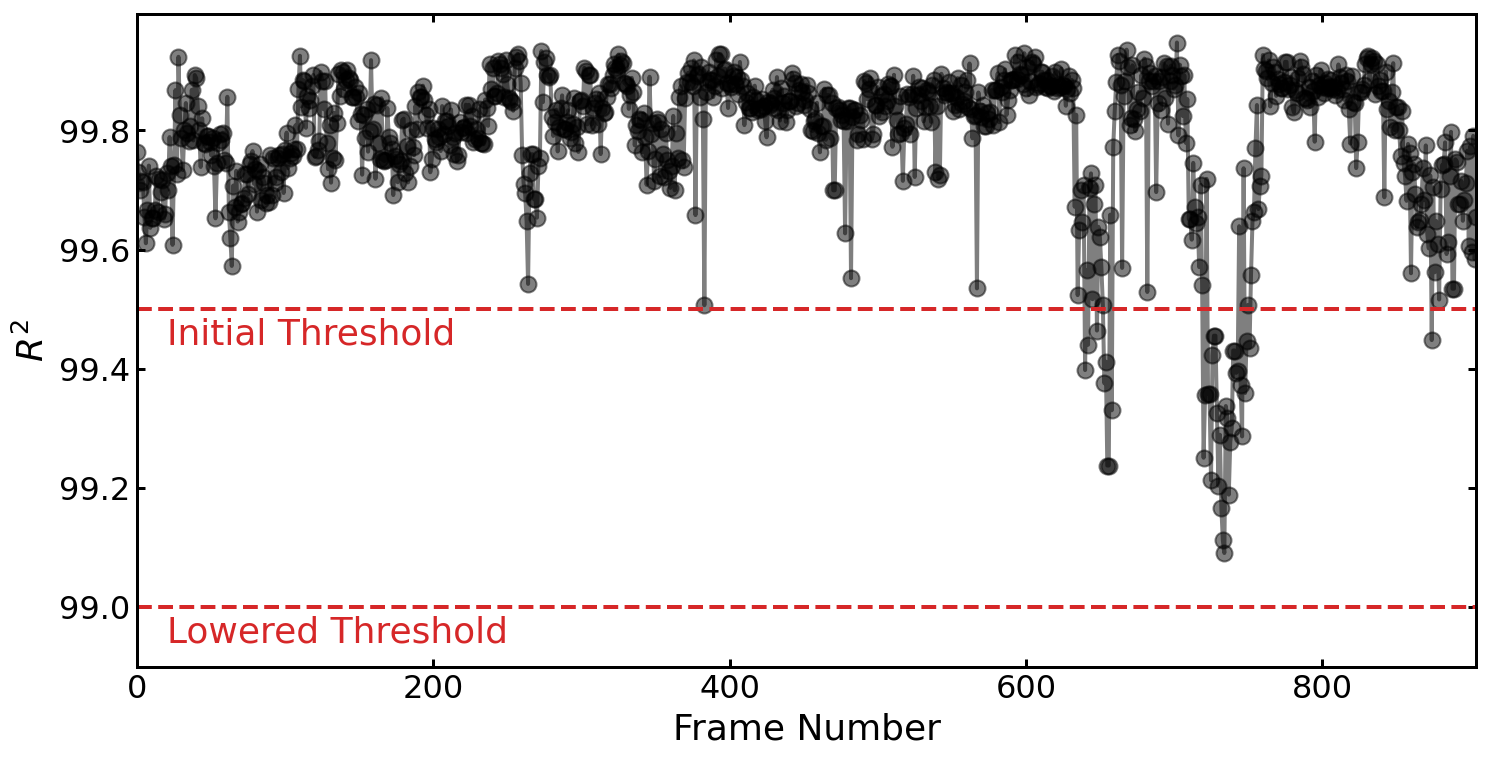

In [21]:
color = 'tab:red'

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(100 * r_sqr_arr, 'ko-', alpha=0.5)

ax.set(xlabel='Frame Number', ylabel='$R^{2}$')

for pos, text in zip([r_sqr_init, r_sqr_init - 0.005], ['Initial Threshold', 'Lowered Threshold']):

    ax.axhline(y=100 * pos, color=color, ls='--')
    ax.text(20, 100 * pos - 0.06, text, size=font_size, color=color)

ax.autoscale(axis='x', tight=True)
ax.set_ylim(bottom=98.9);

<br>

# Results

The final step in our analysis is plotting the data. For this purpose, we average the extracted contrast values for each position and calculate the error. After constructing the time delay array, we can visualise the decay of fringe contrast with time delay.

In [22]:
contrast_values, contrast_errors = [], []

for i in range(0, number_of_positions):
    sup_array, sup_array_2 = [], []
    n_of_fitted = 0

    for j in range(0, frames_per_position):
        k = i * frames_per_position + j
        if (frames_fitted[k] == True):
            sup_array.append(contrast_arr[k])
            sup_array_2.append(contrast_err_arr[k])
            n_of_fitted += 1

    if (n_of_fitted == 0):
        contrast_values.append(0)
        contrast_errors.append(0)
    else:
        contrast_values.append(np.mean(sup_array))
        contrast_errors.append(error_calculation(sup_array_2))

In [23]:
mm_delay = np.arange(data[0]['Position'], data[-1]['Position'] - step, -step)
cm_delay = mm_delay * 0.1

cm_delay = -cm_delay + zero_delay * 0.1
t_delay = 2 * (cm_delay) * (1000 / 30)

summary_df = pd.DataFrame({
    'Delay (cm)': cm_delay,
    'Delay (ps)': t_delay,
    'Contrast': contrast_values,
    'Contrast Error': contrast_errors
})

summary_df = summary_df.head(10).style.format({
    'Delay (cm)': '{:,.3f}',
    'Delay (ps)': '{:,.2f}',
    'Contrast': '{:,.4f}',
    'Contrast Error': '{:,.4f}'
})

print('First 10 data points: ')
summary_df.set_properties(**{'text-align': 'center'})
summary_df

First 10 data points: 


,Delay (cm),Delay (ps),Contrast,Contrast Error
0,-0.280,-18.67,0.9943,0.0002
1,-0.180,-12.00,1.0000,0.0015
2,-0.080,-5.33,1.0000,0.0075
3,0.020,1.33,1.0000,0.0049
4,0.120,8.00,1.0000,0.0018
5,0.220,14.67,0.9847,0.0009
6,0.320,21.33,0.9613,0.0004
7,0.420,28.00,0.9269,0.0005
8,0.520,34.67,0.8860,0.0005
9,0.620,41.33,0.8401,0.0000


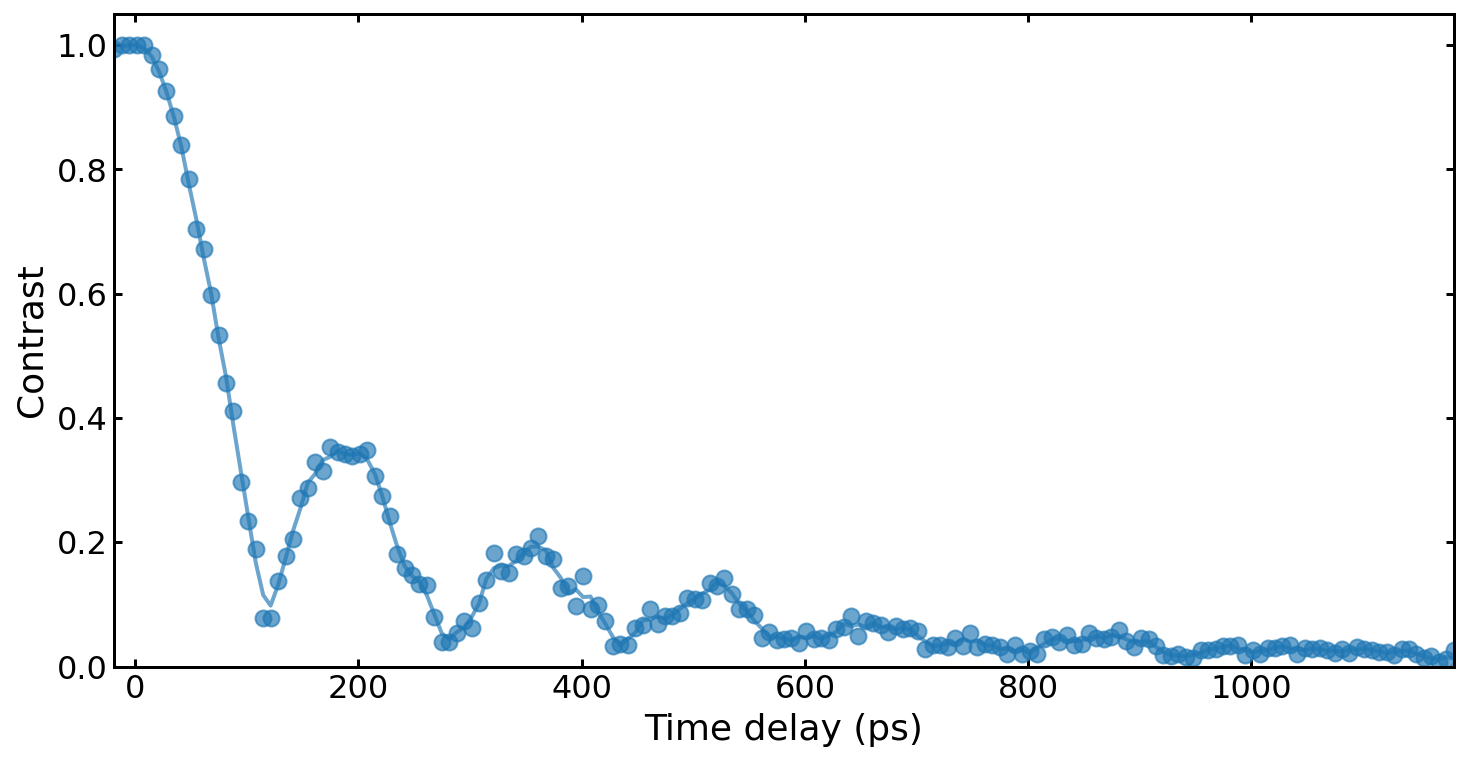

In [24]:
ma = moving_average(contrast_values, 3)
color = 'tab:blue'

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(t_delay, contrast_values, color=color, alpha=0.66, marker='o', ls='')
ax.plot(t_delay[1:], ma[1:], color=color, alpha=0.66)

ax.set(title='', xlabel='Time delay (ps)', ylabel='Contrast')

ax.autoscale(axis='x', tight=True)
ax.set_ylim(bottom=0)

plt.savefig('g(1)_temporal_decay.png');

<br>